In [1]:
# Exploratory Data Analysis (CPU-Bound)

# In this notebook I'll perform EDA to explain feature columns, 
# their relationships and overall everything we should know about the
# given dataset.

In [2]:
# Feature Columns

# time_ms = Timestamp of measurement in milliseconds

# cpu_psi_some_* = Shows how much time tasks are delayed because CPU is saturated. 

# cpu_psi_full_* = Percentage of time all non-idle tasks are stalled, waiting for CPU.  

# io_psi_some_* = Shows delay caused by storage / disk IO.

# io_psi_full_* = All runable tasks blocked on IO.

# mem_psi_some_* = Shows tasks waiting in memory.

# mem_psi_full_* = Shows all tasks stalled due to memory pressure.

# load_avg_* = Average number of runnable or IO-waiting tasks over time windows.

# procs_running = Number of processes currently runable.

# procs_blocked = Number of processes blocked waiting for IO completion.

# procs_disk_io = Processes specifically blocked on disk IO.

# Some -> At least 1 task waiting.
# Full -> Entire workload stalled.

In [3]:
# Imports

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, ks_2samp

sns.set_style("whitegrid")

In [4]:
# Read CSV files

PROJECT_ROOT = Path.cwd().parent.parent
DATASET_DIR = PROJECT_ROOT / "datasets"
PRIO_DIR = DATASET_DIR / "prio-cpu.csv"
RR_DIR = DATASET_DIR / "rr-cpu.csv"

df_prio = pd.read_csv(PRIO_DIR)
df_rr = pd.read_csv(RR_DIR)

# df_prio.head(5)
# df_rr.head(5)

In [5]:
# Add scheduler label
df_prio["scheduler"] = "PRIORITY"
df_rr["scheduler"] = "RR"

# Add ID for both
df_prio["id"] = df_prio.index + 1
df_rr["id"] = df_rr.index + 1

In [6]:
# Combine
df = pd.concat([df_prio, df_rr], ignore_index=True)

In [7]:
# Basic Cleaning

# Sort by scheduler + time
df = df.sort_values(["scheduler", "time_ms"])

# Check missing
print(df.isna().sum())

time_ms             0
cpu_psi_some_10     0
cpu_psi_some_60     0
cpu_psi_some_300    0
cpu_psi_full_10     0
cpu_psi_full_60     0
cpu_psi_full_300    0
io_psi_some_10      0
io_psi_some_60      0
io_psi_some_300     0
io_psi_full_10      0
io_psi_full_60      0
io_psi_full_300     0
mem_psi_some_10     0
mem_psi_some_60     0
mem_psi_some_300    0
mem_psi_full_10     0
mem_psi_full_60     0
mem_psi_full_300    0
load_avg_1          0
load_avg_5          0
load_avg_15         0
procs_running       0
procs_blocked       0
procs_disk_io       0
scheduler           0
id                  0
dtype: int64


In [8]:
# Summary stats per scheduler

metrics = [c for c in df.columns if not c in ["time_ms", "scheduler"]]

summary = df.groupby("scheduler")[metrics].agg([
    "mean",
    "std",
    "median",
    # TODO Add quantiles to summary
    "max"
])

print(summary)

          cpu_psi_some_10                         cpu_psi_some_60            \
                     mean       std median    max            mean       std   
scheduler                                                                     
PRIORITY        16.584179  2.024765  16.31  21.44       15.698680  2.888478   
RR              15.830174  1.725423  15.88  19.70       15.481361  1.701262   

                        cpu_psi_some_300            ... procs_blocked      \
          median    max             mean       std  ...        median max   
scheduler                                           ...                     
PRIORITY   16.28  19.55        11.851580  4.292664  ...           0.0   2   
RR         15.87  17.20        15.828004  0.312363  ...           0.0   1   

          procs_disk_io                     id                          
                   mean  std median max   mean         std median  max  
scheduler                                                               

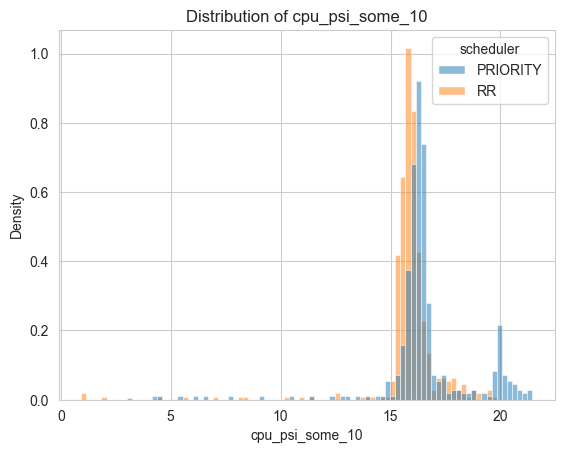

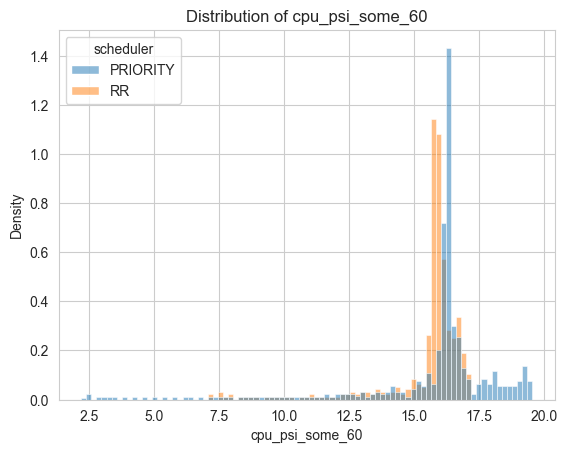

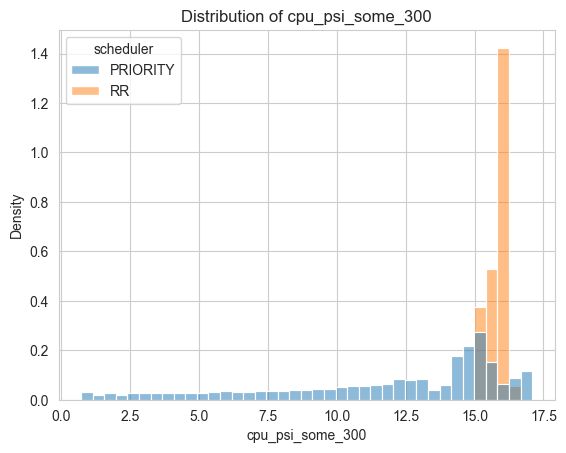

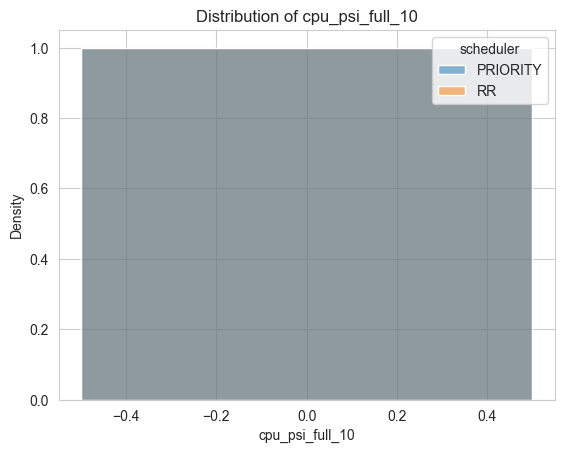

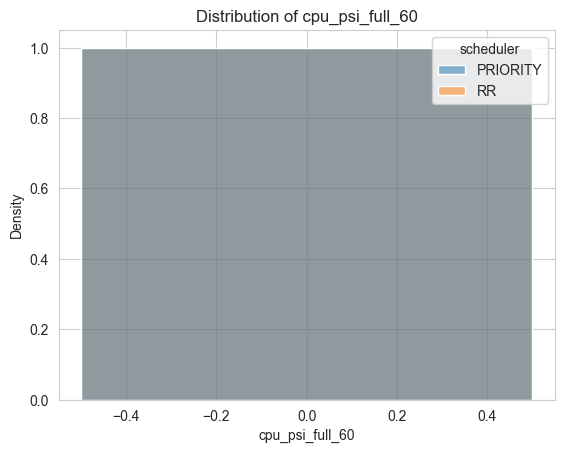

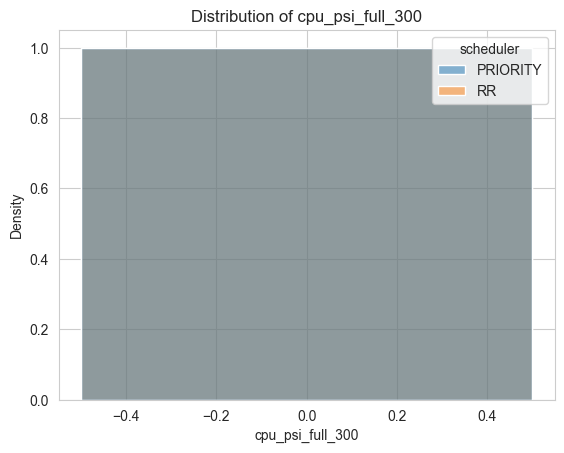

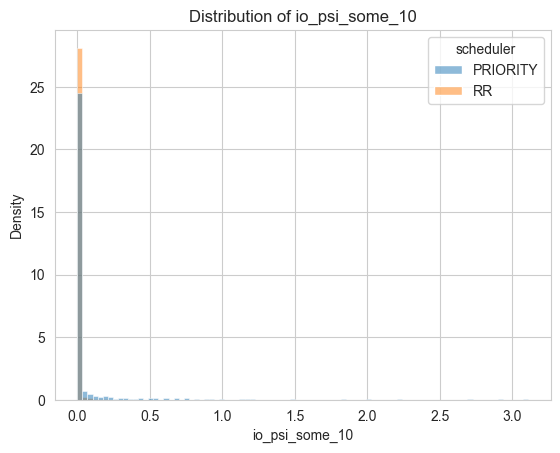

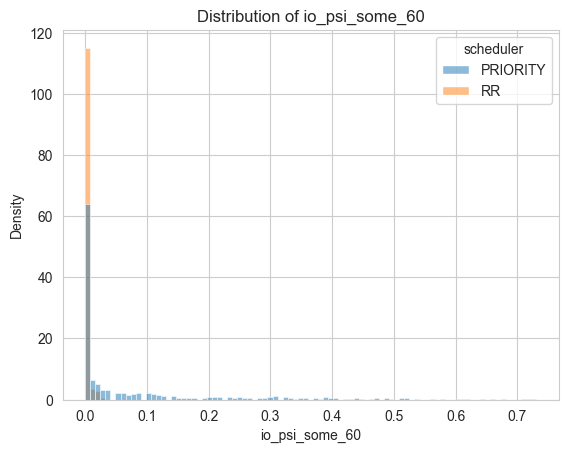

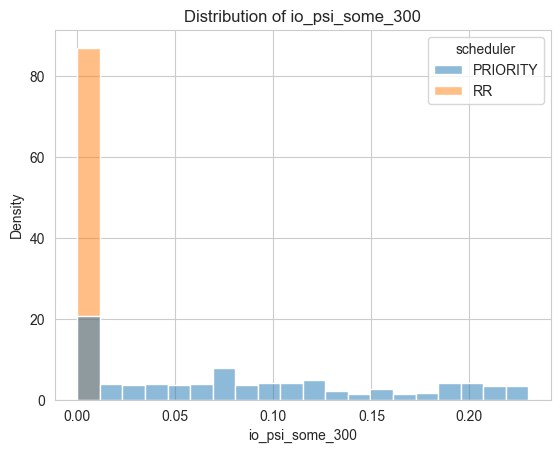

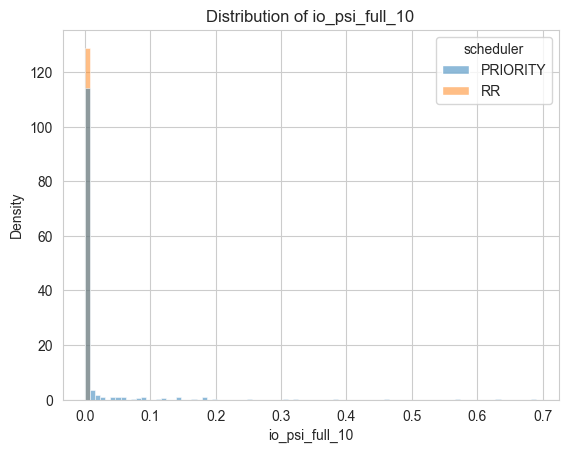

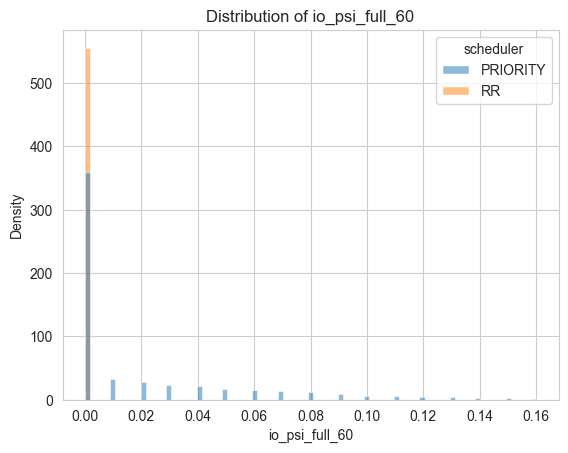

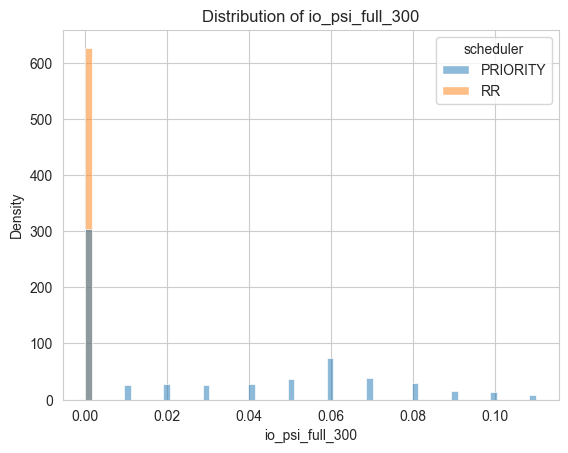

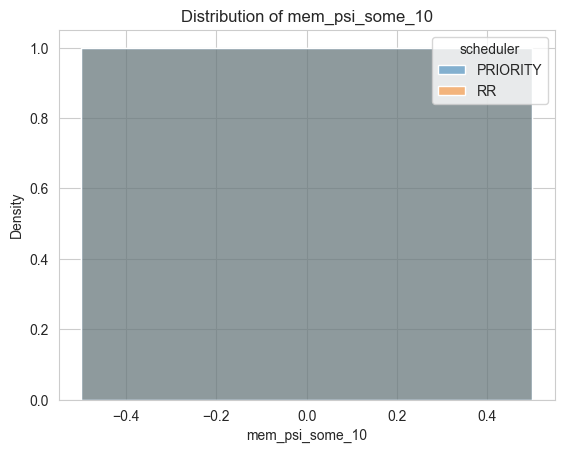

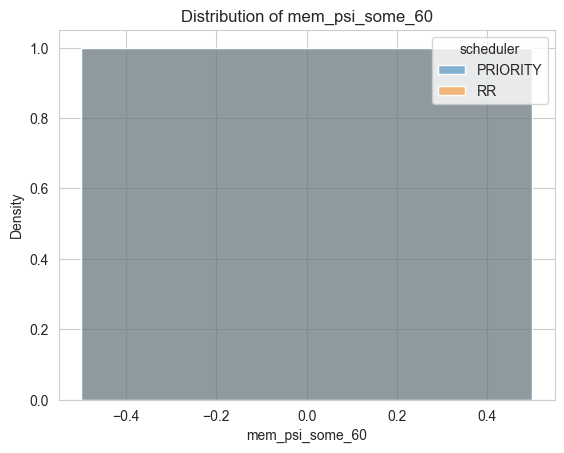

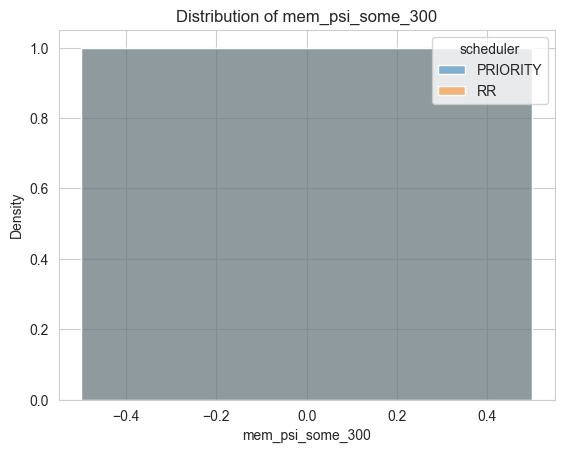

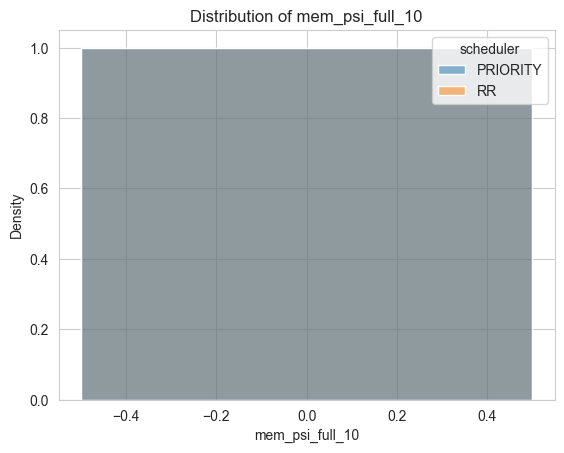

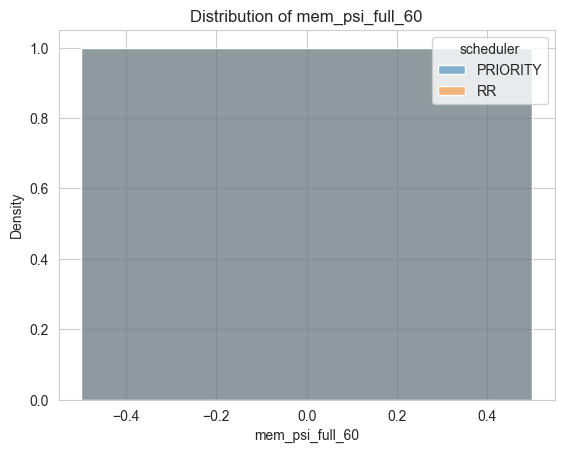

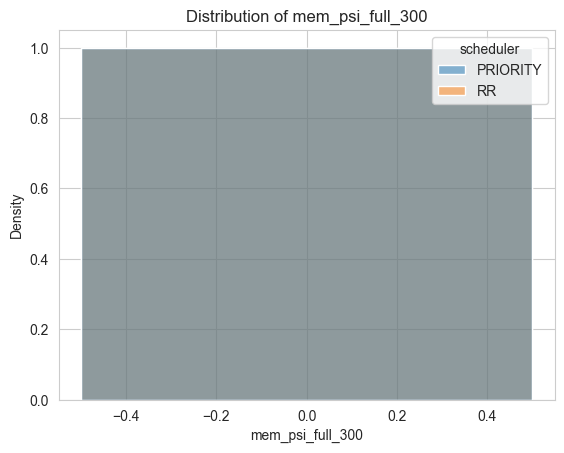

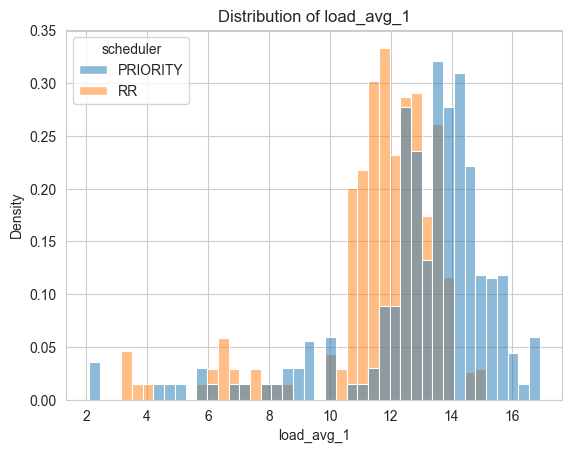

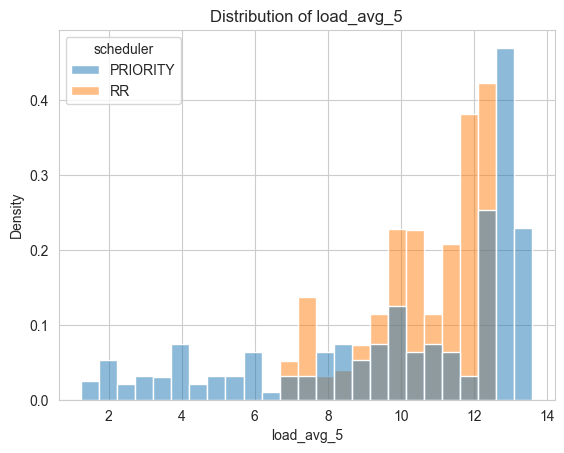

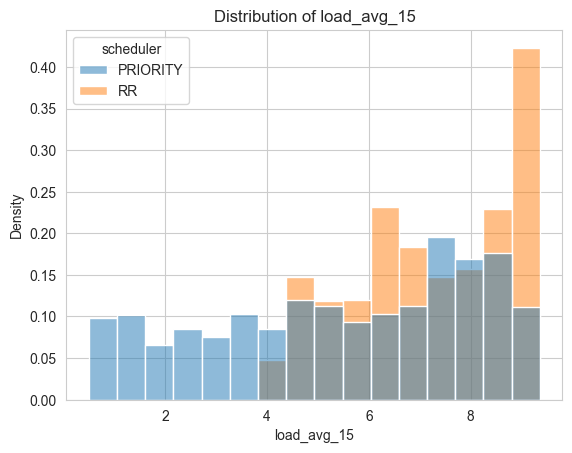

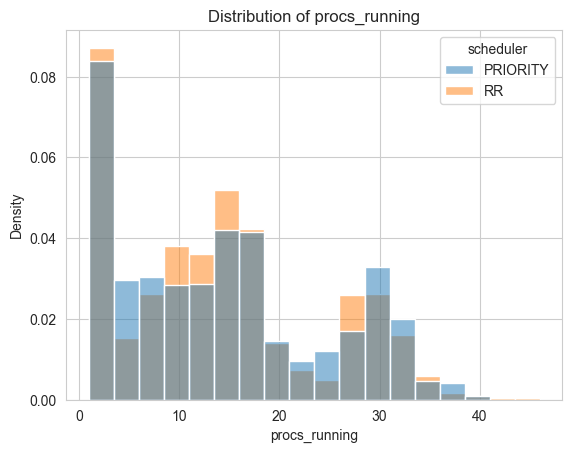

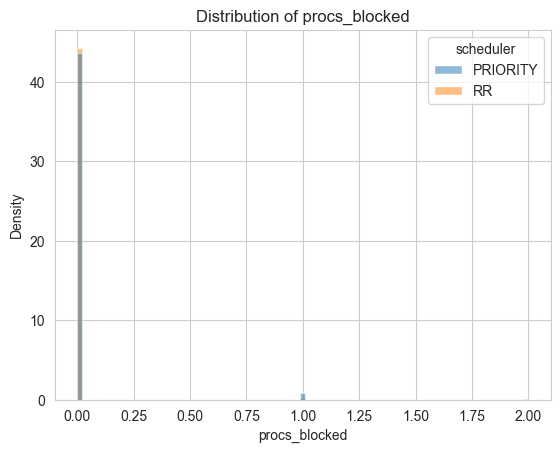

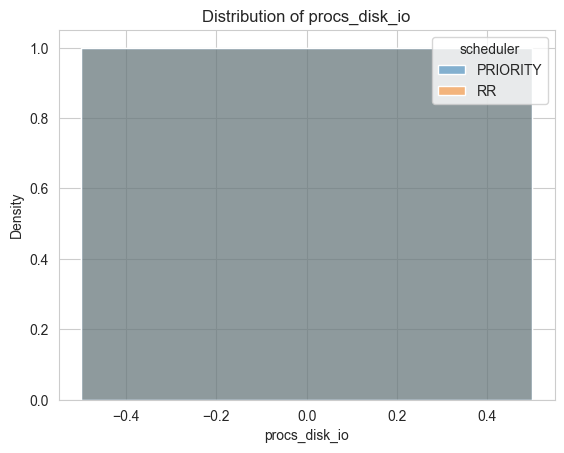

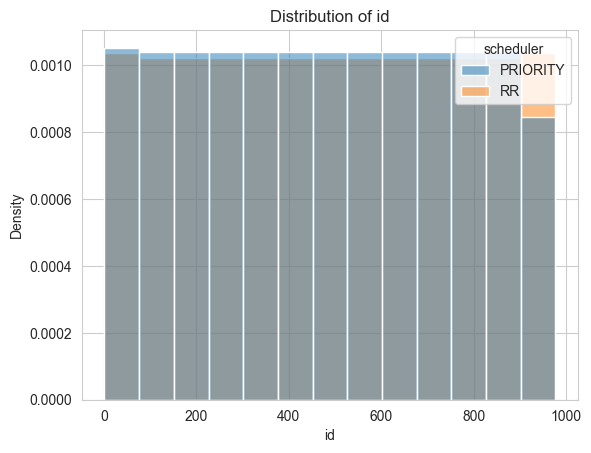

In [9]:
# Distribution Comparison - Histogram
for col in metrics:
    plt.figure()
    sns.histplot(data=df, x=col, hue="scheduler", kde=False, stat="density", common_norm=False)
    # KDE is off due to data having lots of zeroes, can't compute the line
    plt.title(f"Distribution of {col}")
    plt.show()

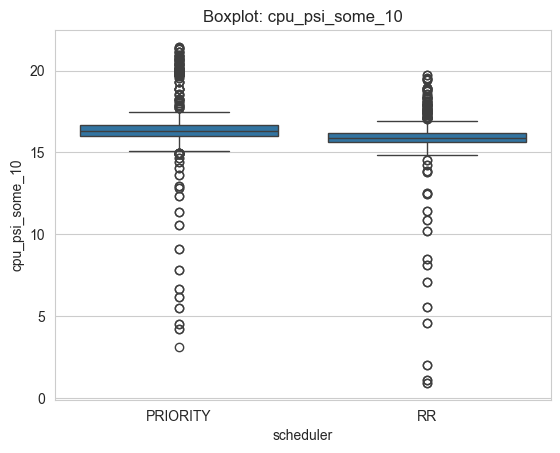

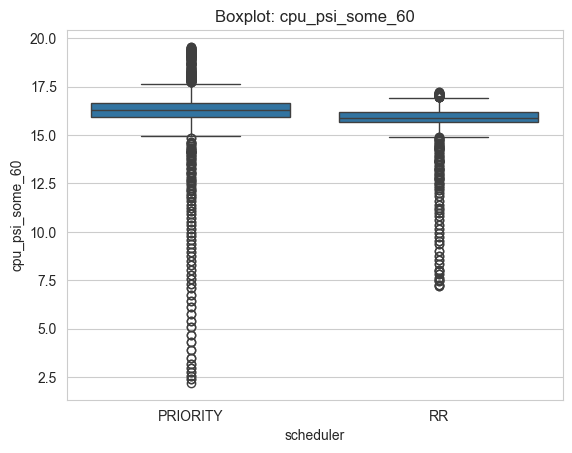

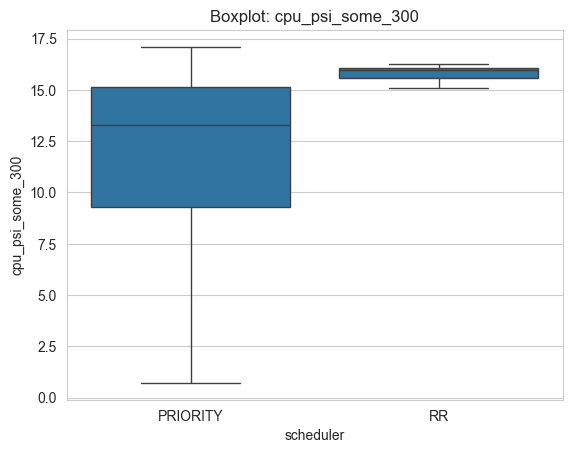

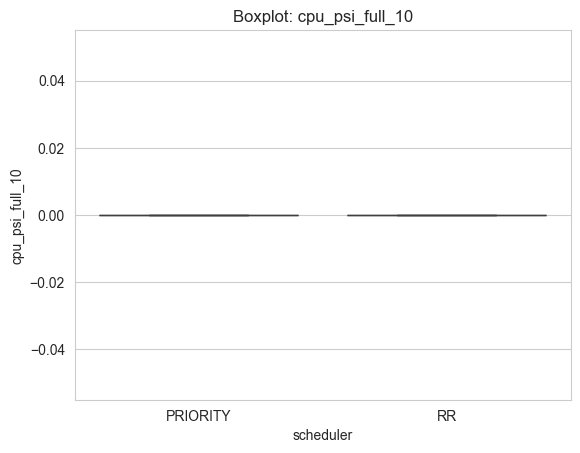

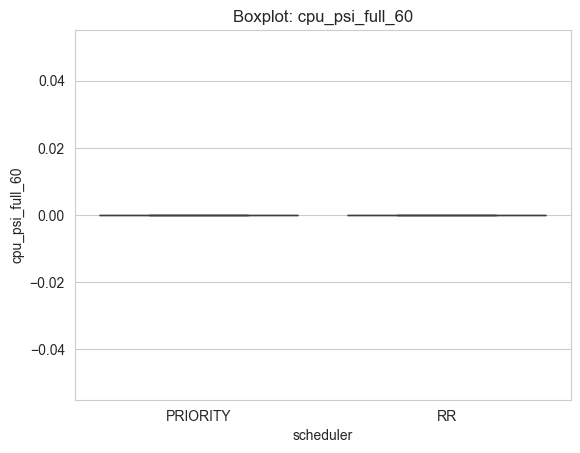

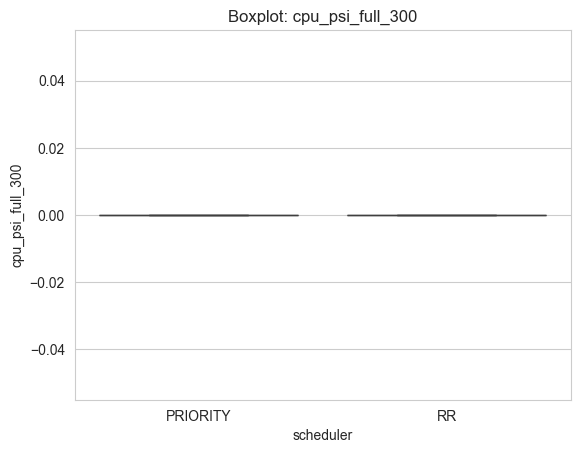

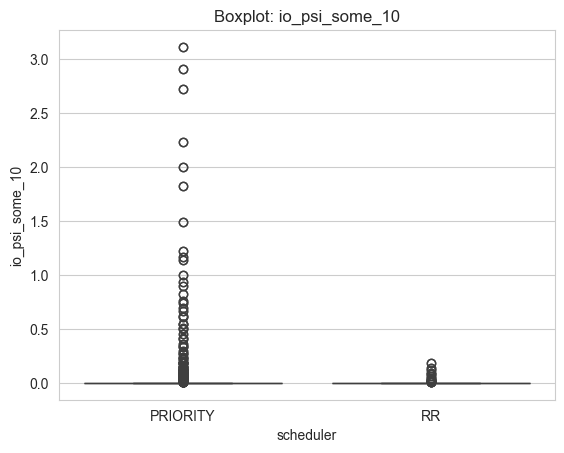

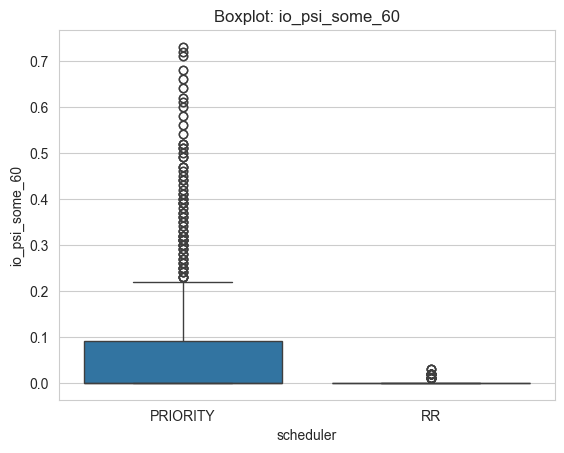

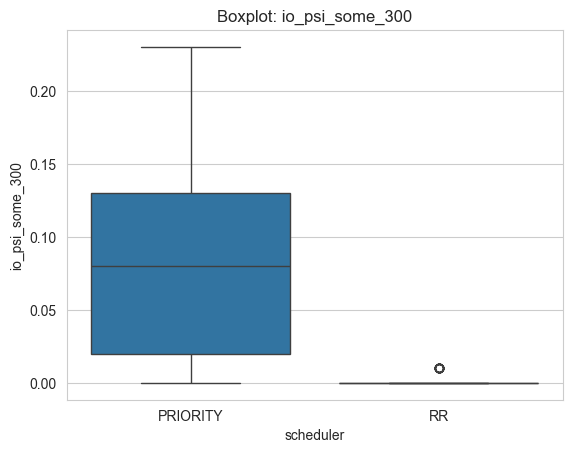

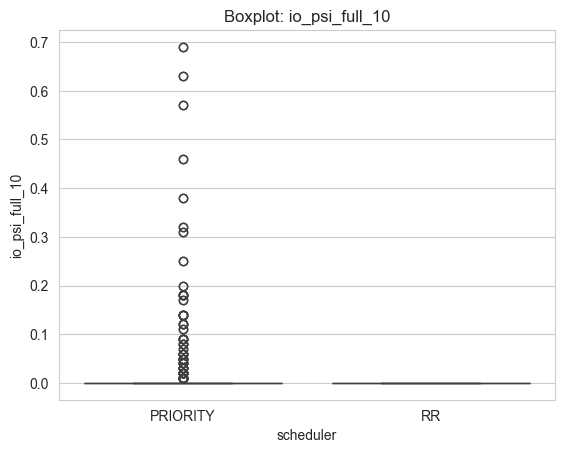

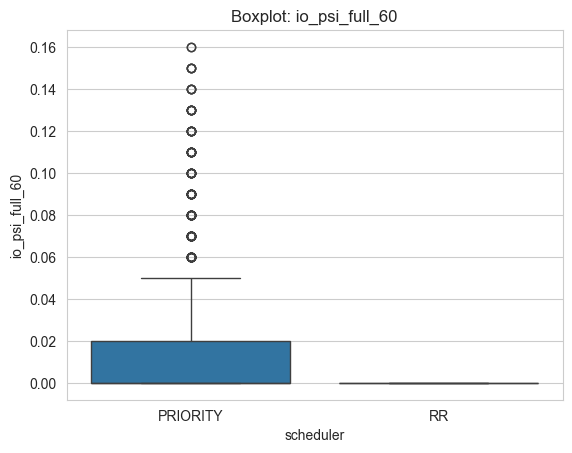

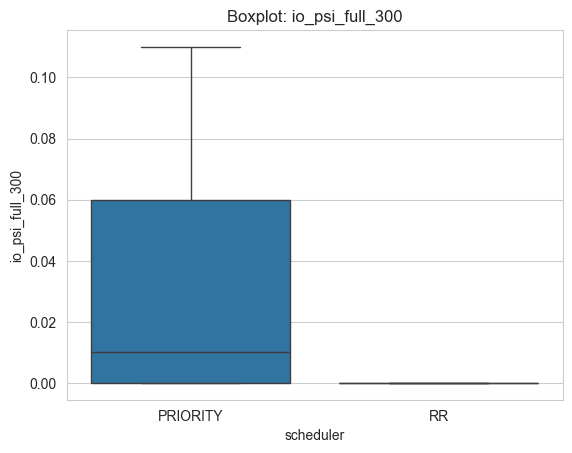

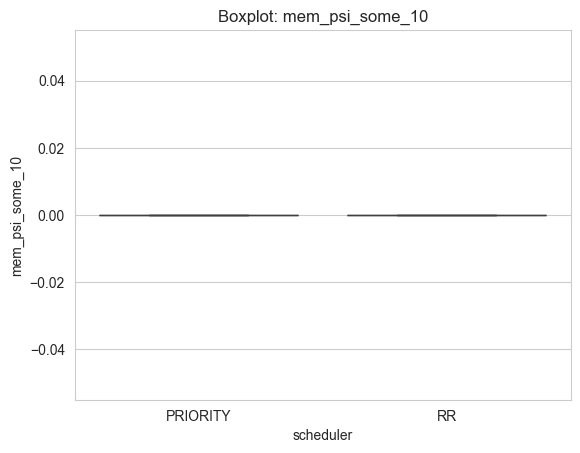

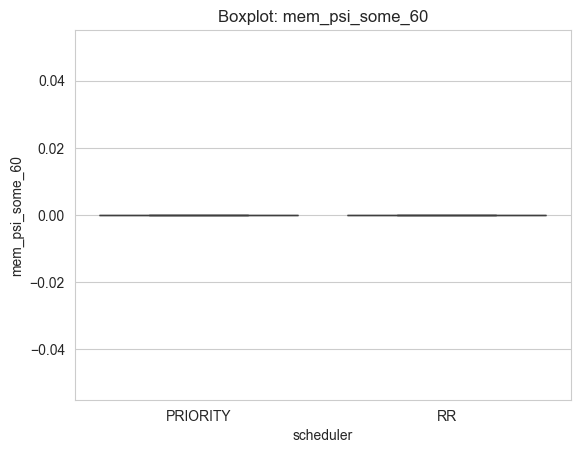

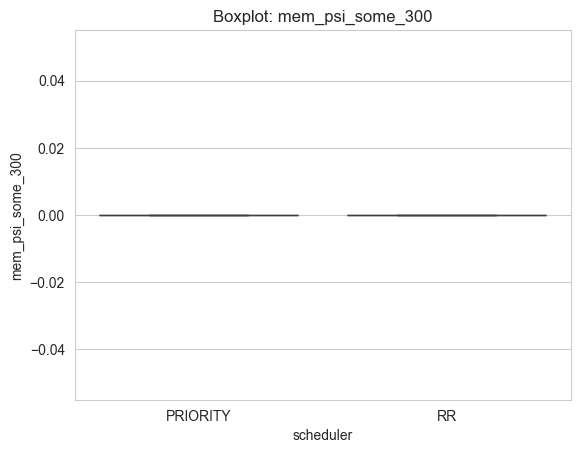

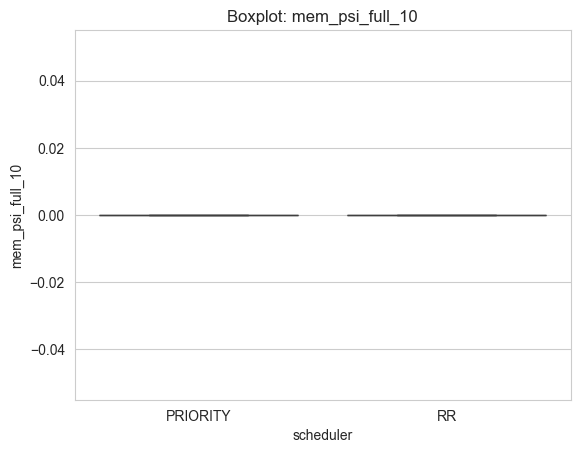

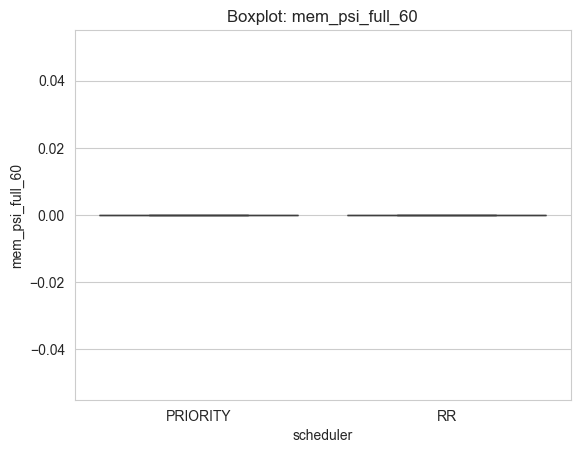

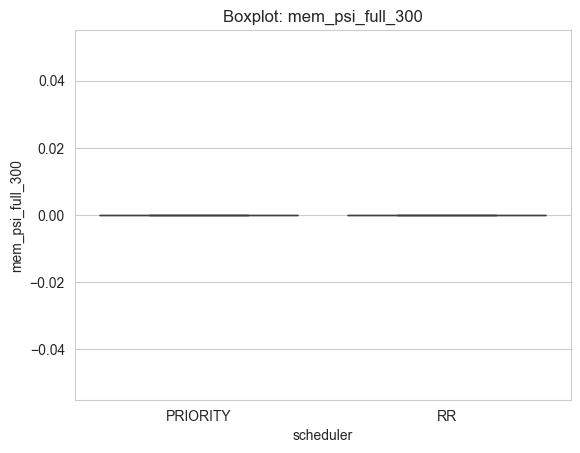

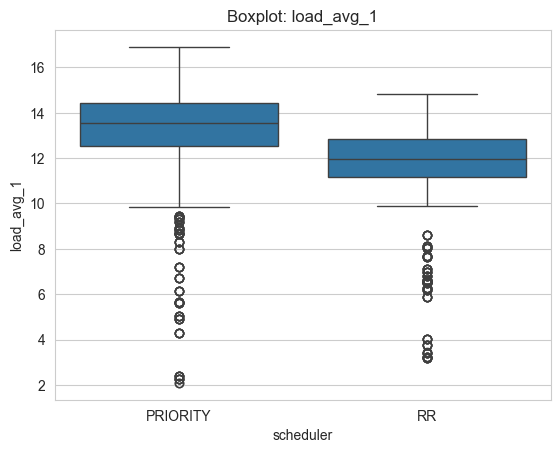

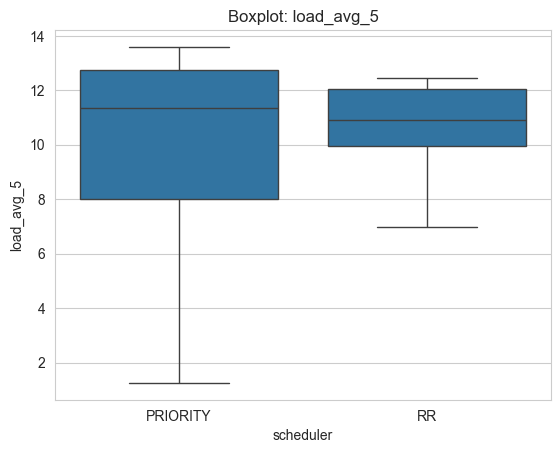

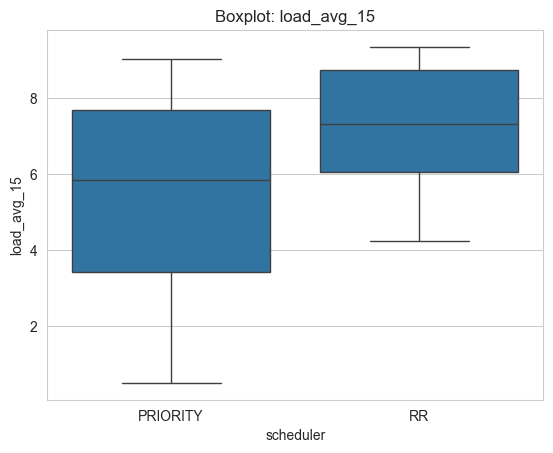

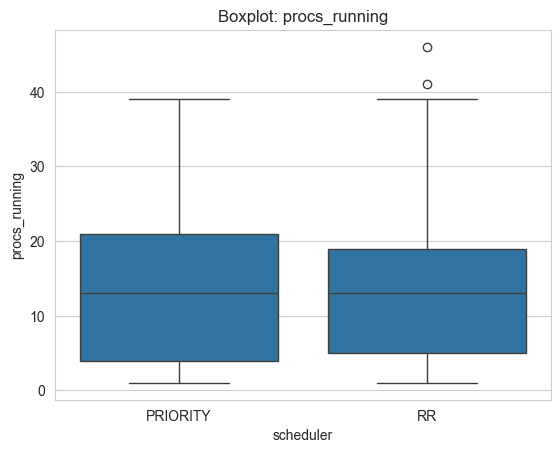

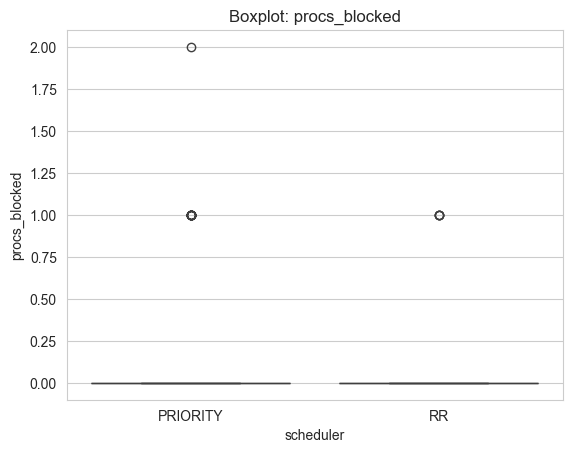

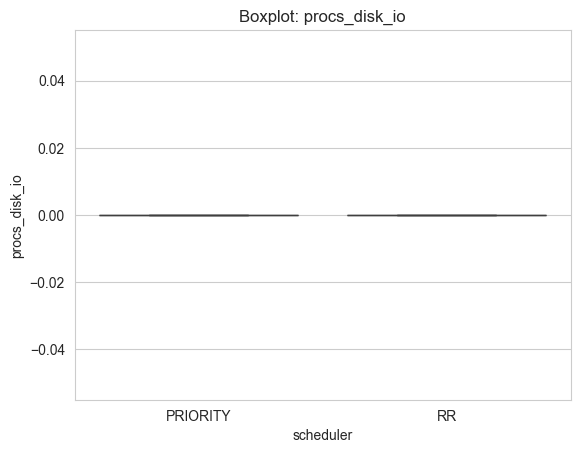

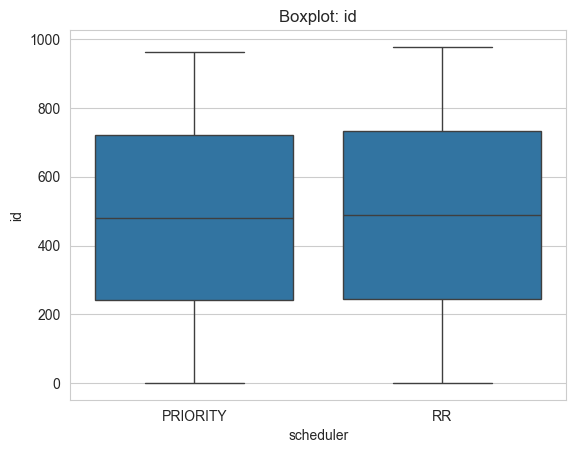

In [10]:
# Distribution Comparison - Boxplots
for col in metrics:
    plt.figure()
    sns.boxplot(data=df, x="scheduler", y=col)
    plt.title(f"Boxplot: {col}")
    plt.show()

In [11]:
# Spike / Stall Detection

CPU_THRESHOLD = 5 # Adjustable

# TODO Map to different features to see how different schedulers behave.
df["cpu_stall_event"] = df["cpu_psi_some_10"] > CPU_THRESHOLD

# Event Frequency by Scheduler
stall_freq = df.groupby("scheduler")["cpu_stall_event"].mean()
print("CPU Stall Frequency: ")
print(stall_freq)

CPU Stall Frequency: 
scheduler
PRIORITY    0.994802
RR          0.991812
Name: cpu_stall_event, dtype: float64


In [12]:
def compute_event_durations(series):
    durations = []
    current = 0

    for val in series:
        if val:
            current += 1
        else:
            if current > 0:
                durations.append(current)
            current = 0

    if current > 0:
        durations.append(current)

    return durations

In [13]:
for sched in df["scheduler"].unique():
    s = df[df["scheduler"] == sched]["cpu_stall_event"]
    durations = compute_event_durations(s)
    
    print(f"Scheduler {sched} mean duration:", np.mean(durations) if durations else 0)
    # TODO This output means schedulers always stall. Up to Doğu to interpret.

Scheduler PRIORITY mean duration: 957.0
Scheduler RR mean duration: 969.0


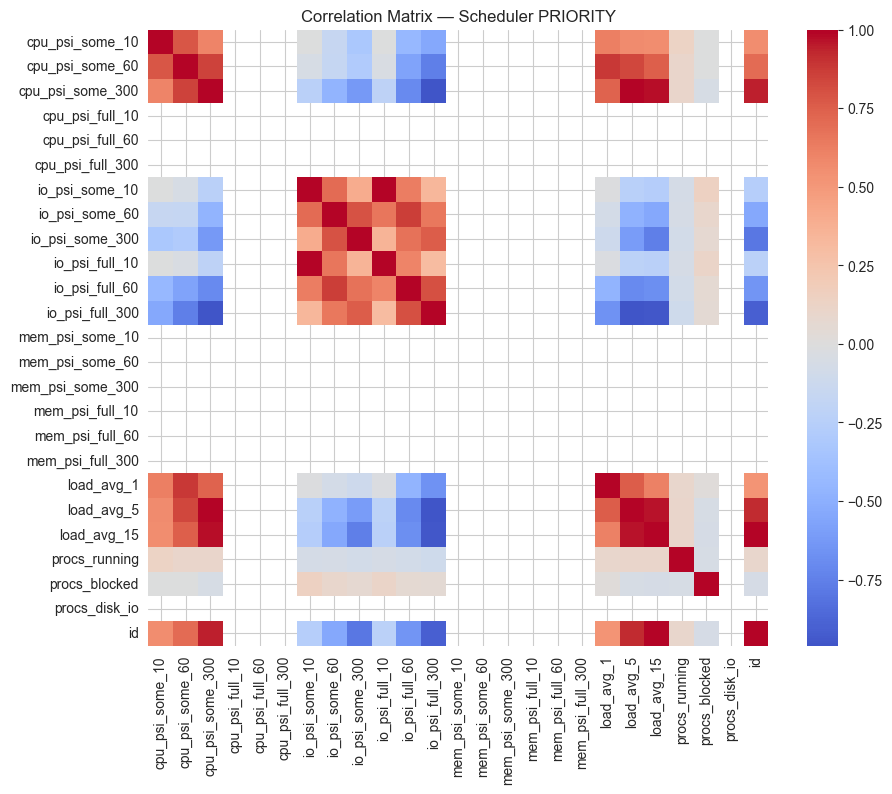

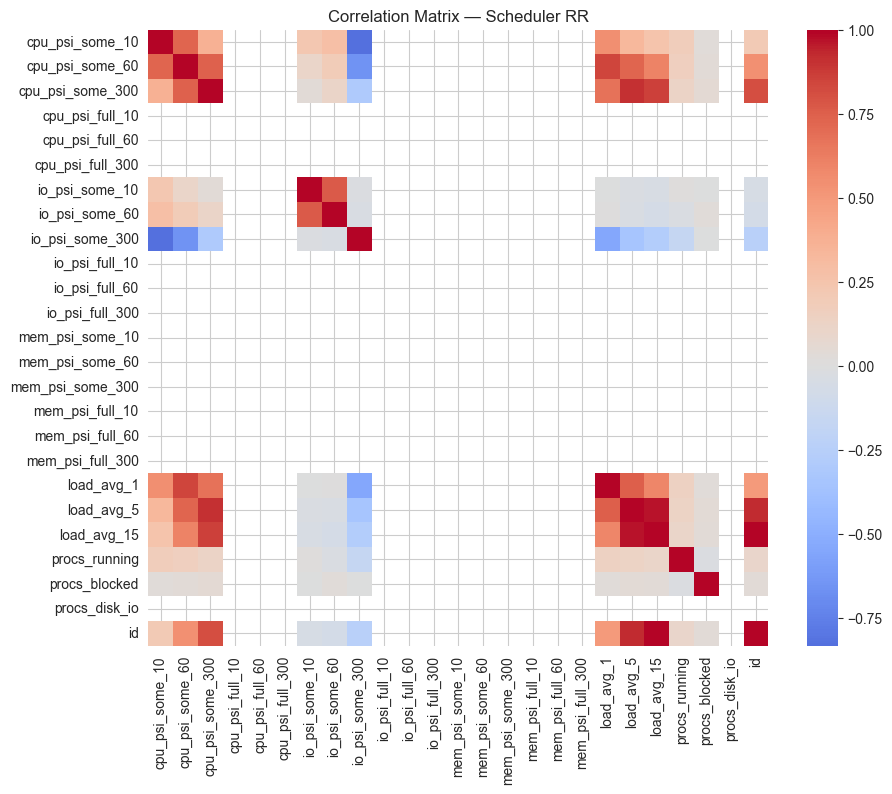

In [14]:
# Correlation Structure
for sched in df["scheduler"].unique():
    plt.figure(figsize=(10,8))
    
    sub = df[df["scheduler"] == sched][metrics]
    corr = sub.corr()
    
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(f"Correlation Matrix — Scheduler {sched}")
    plt.show()

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


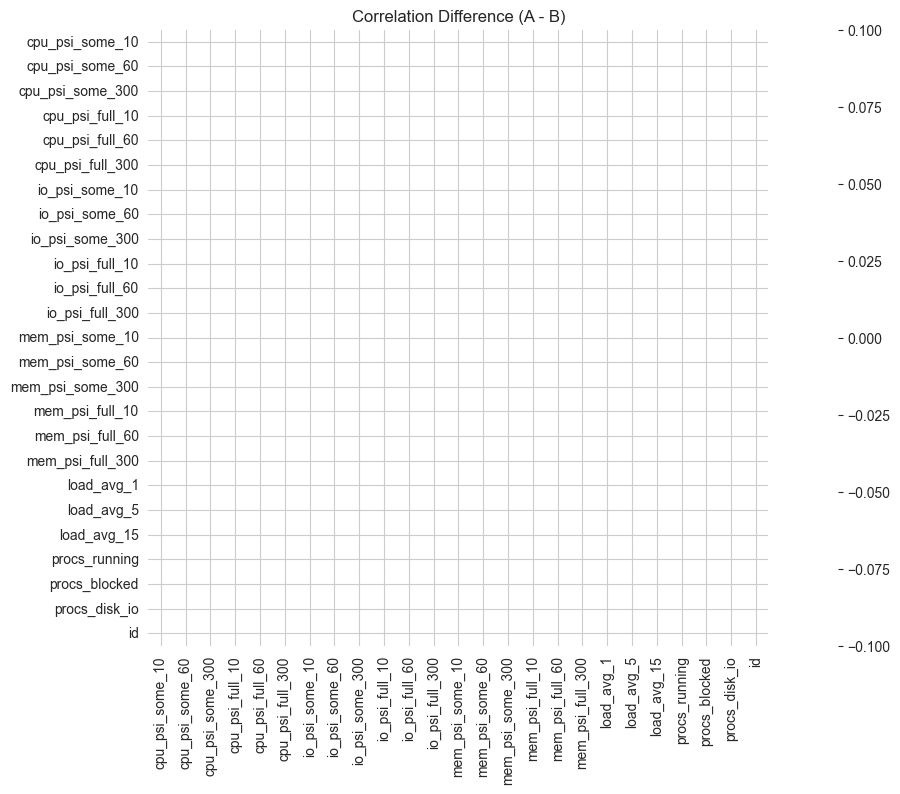

In [15]:
# Correlation Difference
corr_A = df[df.scheduler=="A"][metrics].corr()
corr_B = df[df.scheduler=="B"][metrics].corr()

corr_diff = corr_A - corr_B

plt.figure(figsize=(10,8))
sns.heatmap(corr_diff, cmap="coolwarm", center=0)
plt.title("Correlation Difference (A - B)")
plt.show()

In [16]:
# Statistical Testing
stats_results = []

for col in metrics:
    A_vals = df[df.scheduler=="A"][col].dropna()
    B_vals = df[df.scheduler=="B"][col].dropna()
    
    u_stat, u_p = mannwhitneyu(A_vals, B_vals, alternative="two-sided")
    ks_stat, ks_p = ks_2samp(A_vals, B_vals)
    
    stats_results.append({
        "metric": col,
        "mannwhitney_p": u_p,
        "ks_p": ks_p
    })

stats_df = pd.DataFrame(stats_results)
print(stats_df.sort_values("mannwhitney_p"))
# Terrible output due to similar or full of zero columns.


              metric  mannwhitney_p  ks_p
0    cpu_psi_some_10            NaN   NaN
1    cpu_psi_some_60            NaN   NaN
2   cpu_psi_some_300            NaN   NaN
3    cpu_psi_full_10            NaN   NaN
4    cpu_psi_full_60            NaN   NaN
5   cpu_psi_full_300            NaN   NaN
6     io_psi_some_10            NaN   NaN
7     io_psi_some_60            NaN   NaN
8    io_psi_some_300            NaN   NaN
9     io_psi_full_10            NaN   NaN
10    io_psi_full_60            NaN   NaN
11   io_psi_full_300            NaN   NaN
12   mem_psi_some_10            NaN   NaN
13   mem_psi_some_60            NaN   NaN
14  mem_psi_some_300            NaN   NaN
15   mem_psi_full_10            NaN   NaN
16   mem_psi_full_60            NaN   NaN
17  mem_psi_full_300            NaN   NaN
18        load_avg_1            NaN   NaN
19        load_avg_5            NaN   NaN
20       load_avg_15            NaN   NaN
21     procs_running            NaN   NaN
22     procs_blocked            Na

C:\Users\USER\AppData\Local\Temp\ipykernel_9892\1599359469.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, u_p = mannwhitneyu(A_vals, B_vals, alternative="two-sided")
C:\Users\USER\AppData\Local\Temp\ipykernel_9892\1599359469.py:9: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ks_stat, ks_p = ks_2samp(A_vals, B_vals)


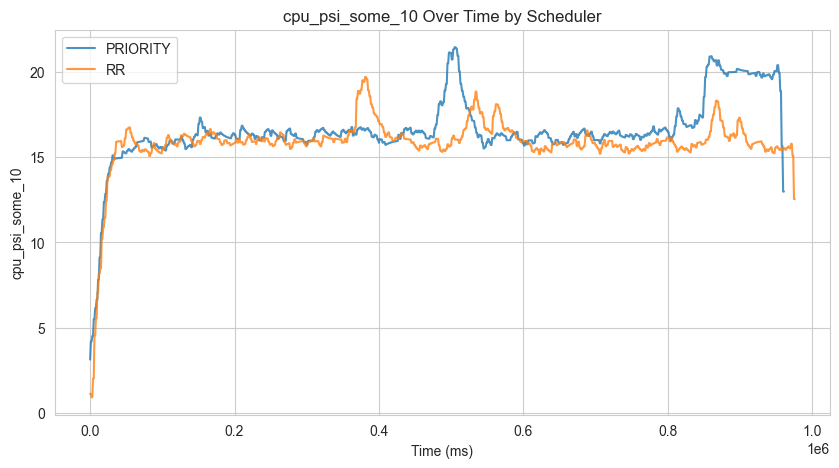

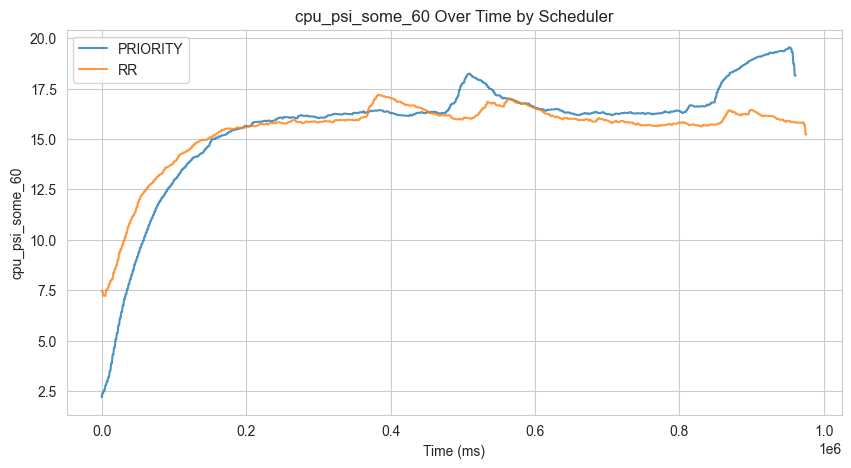

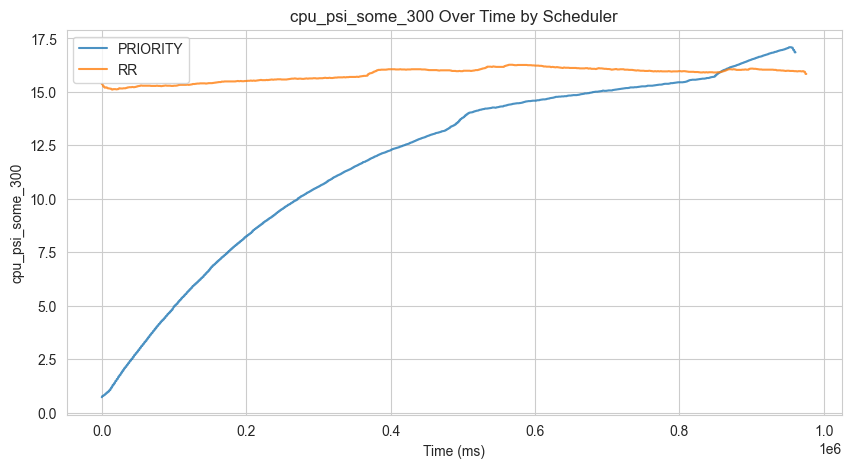

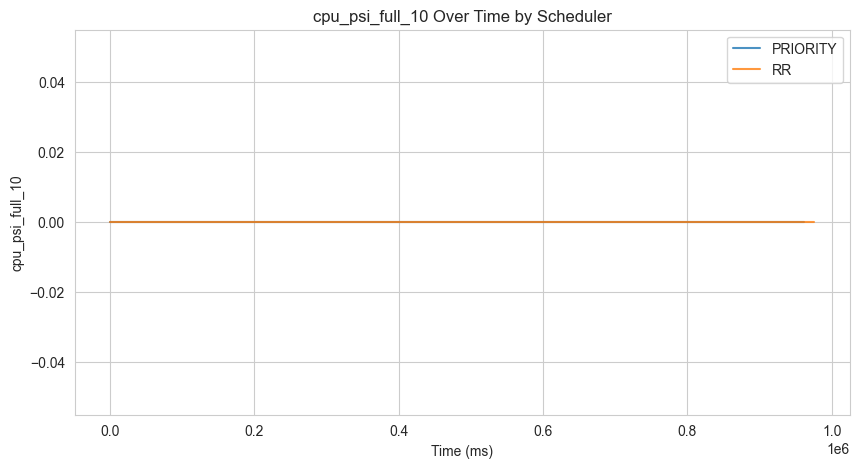

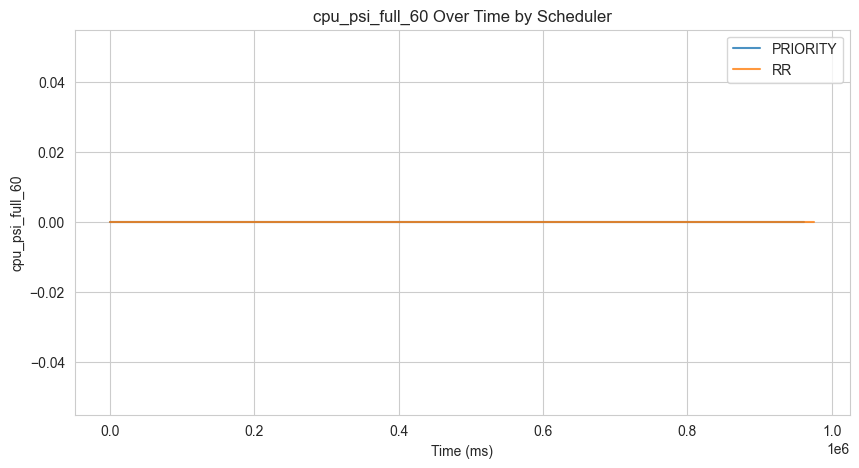

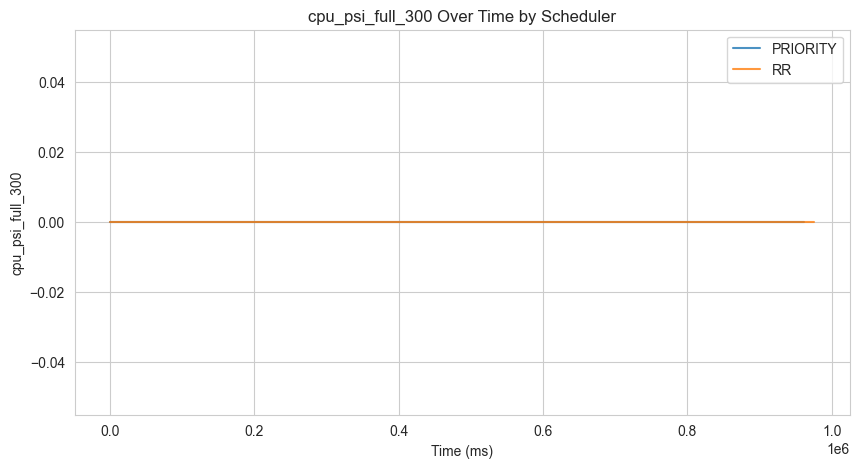

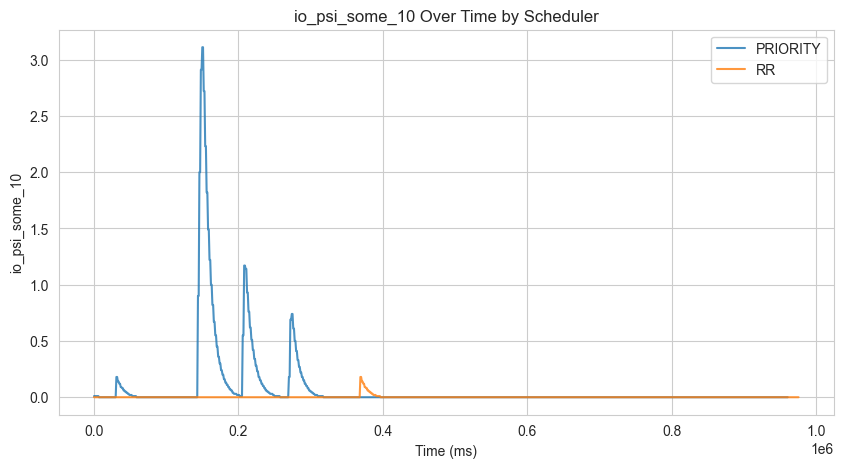

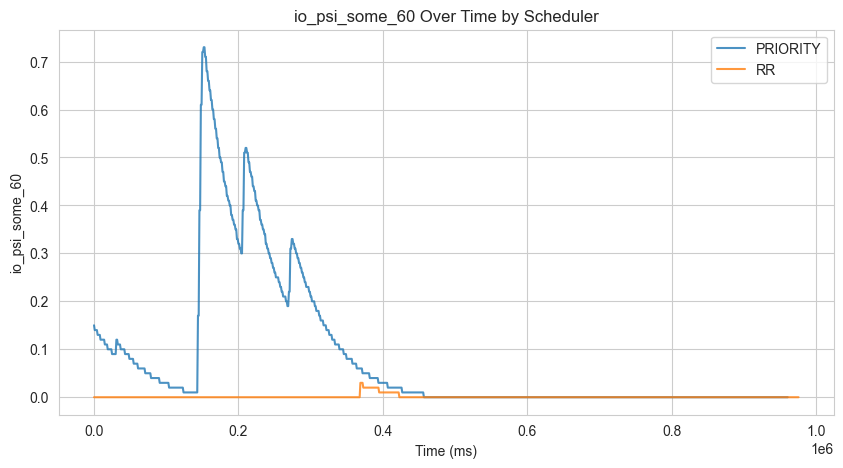

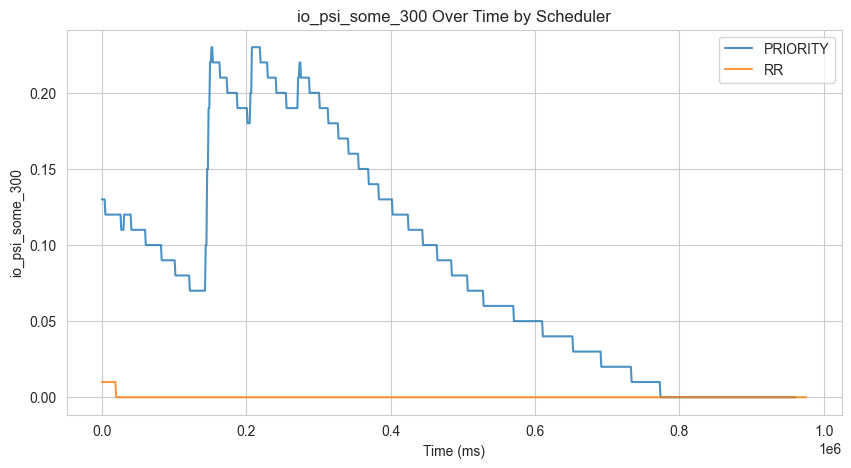

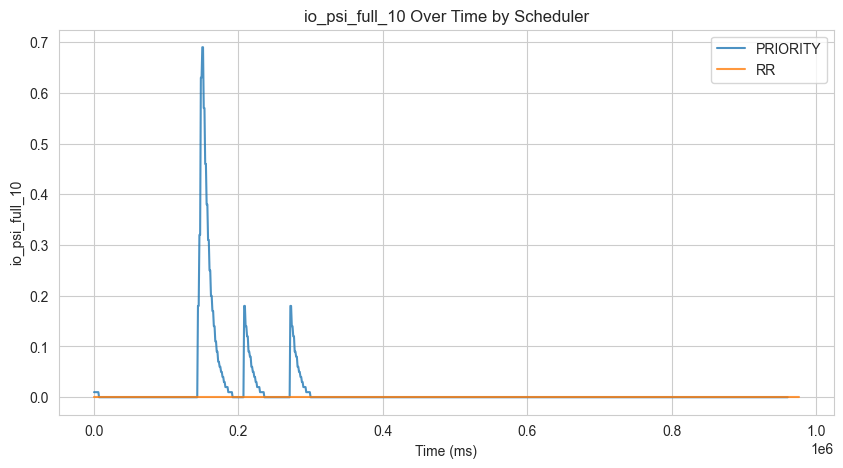

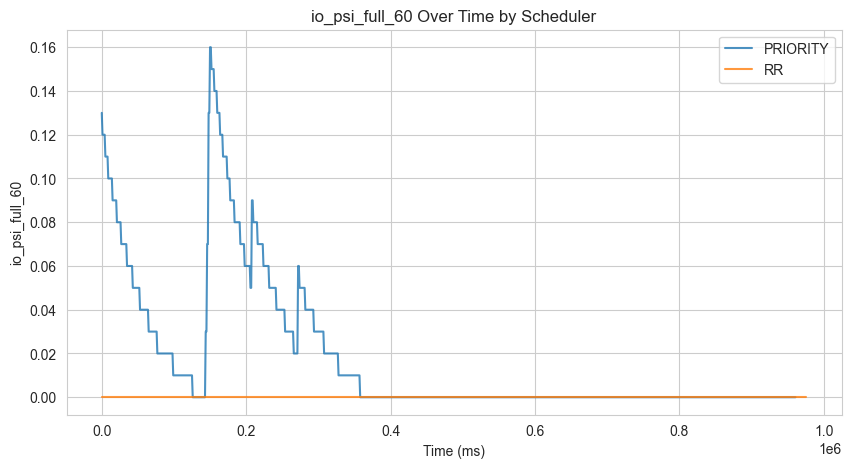

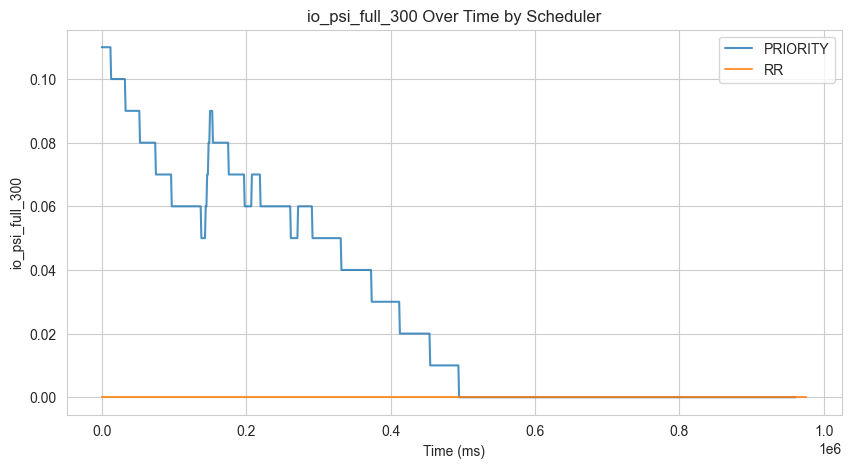

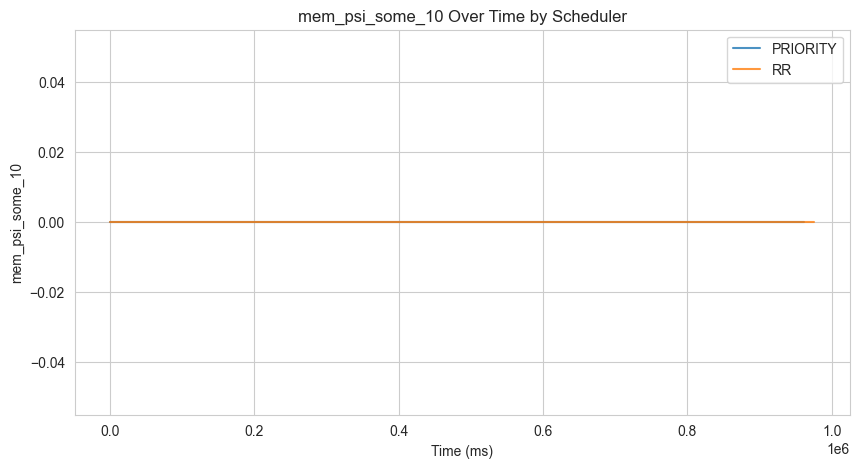

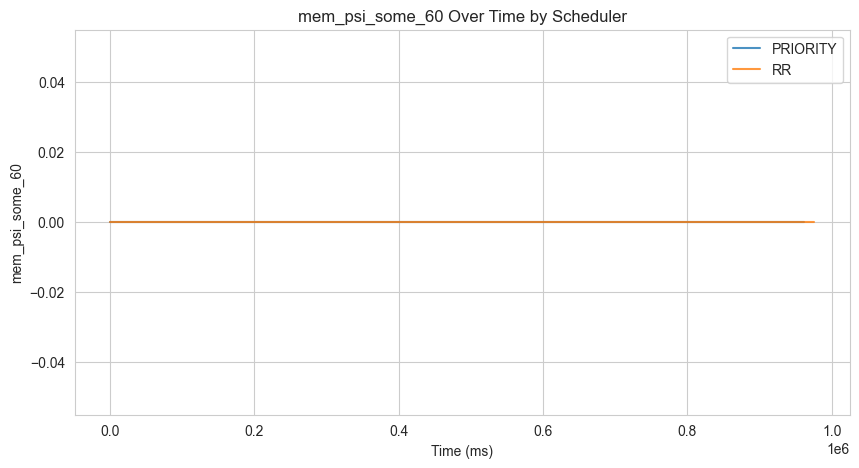

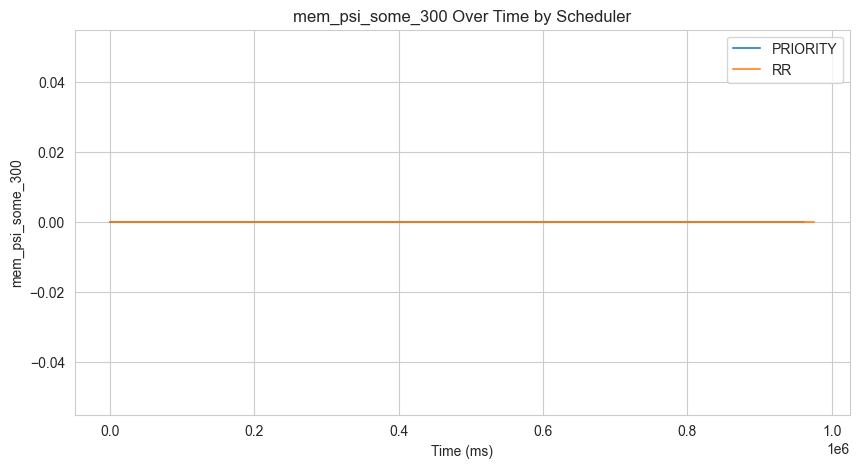

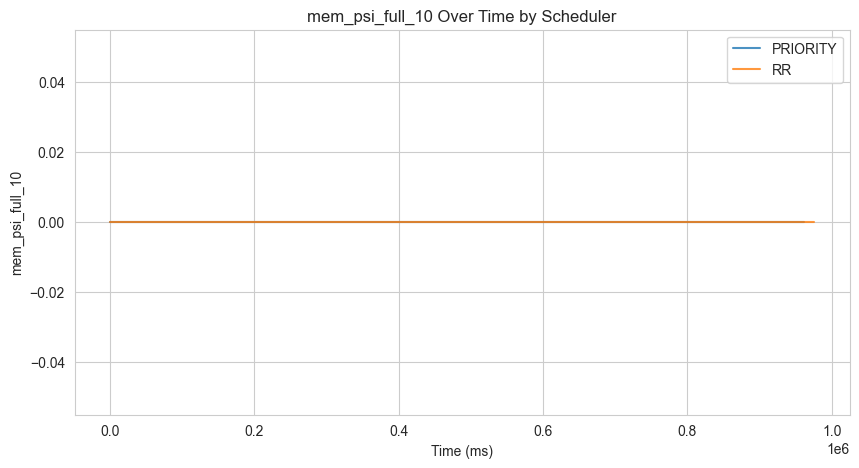

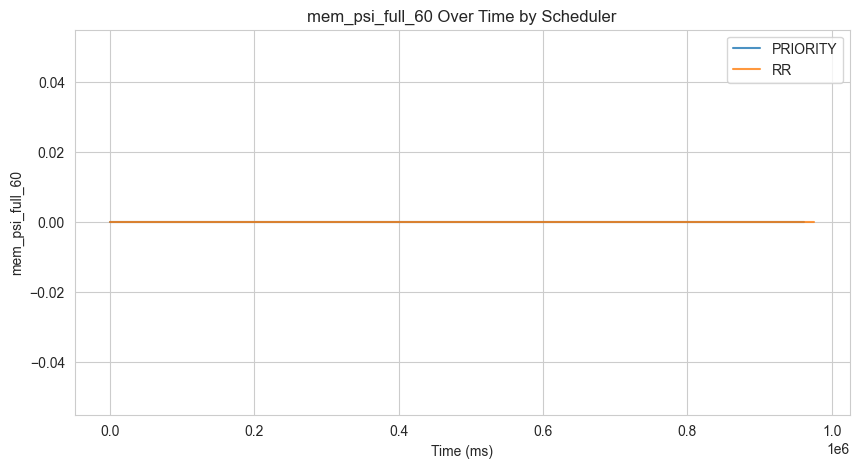

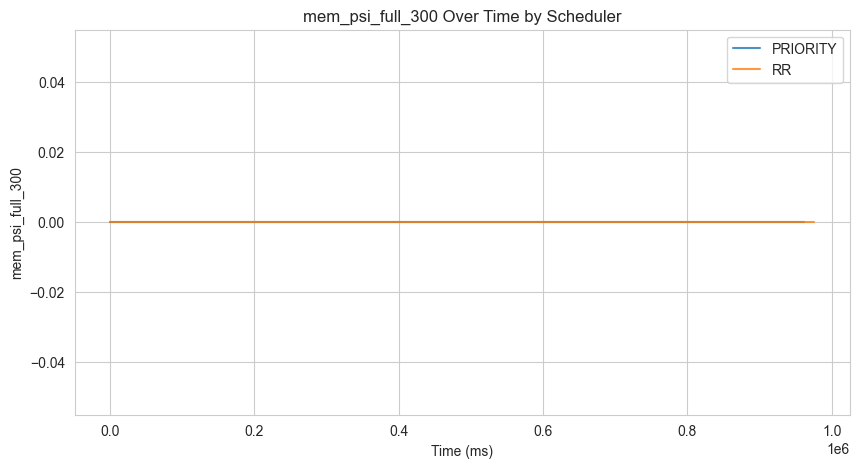

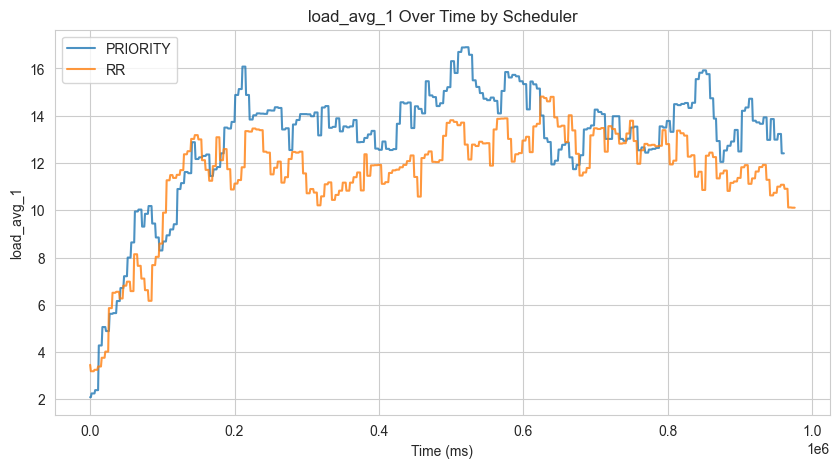

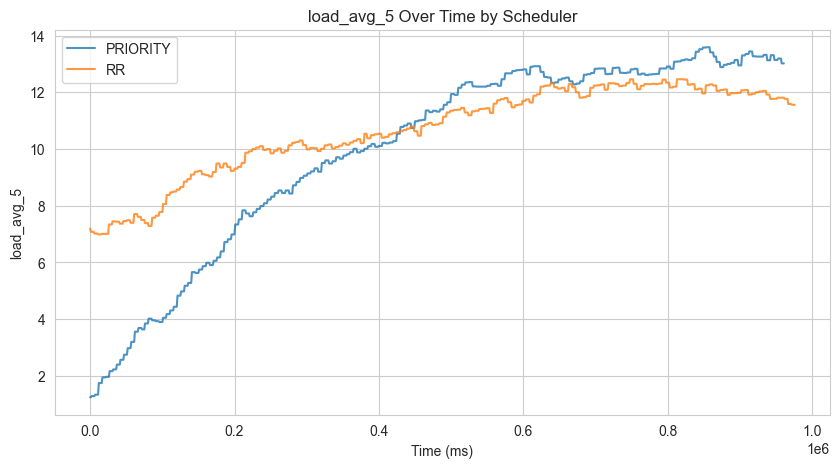

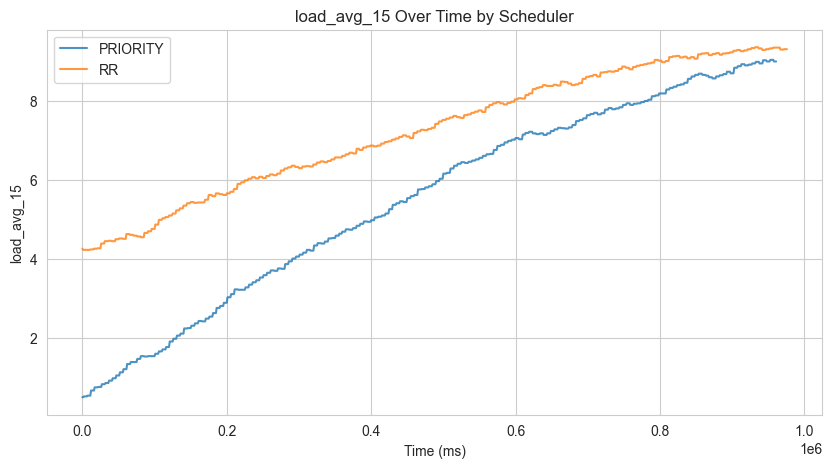

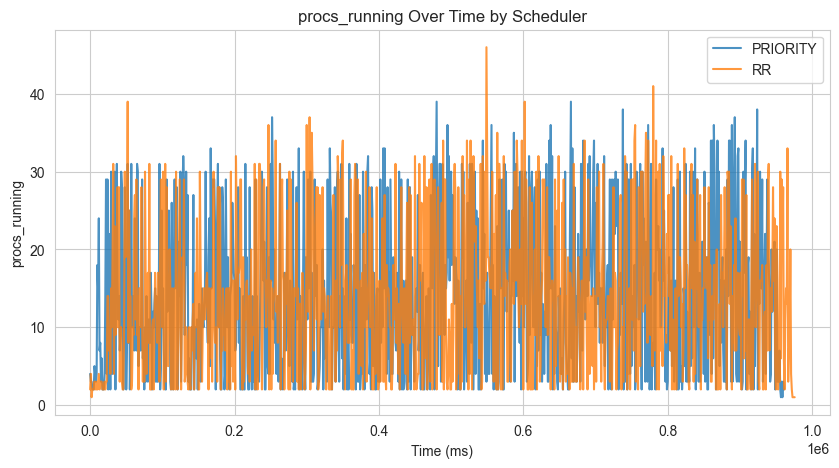

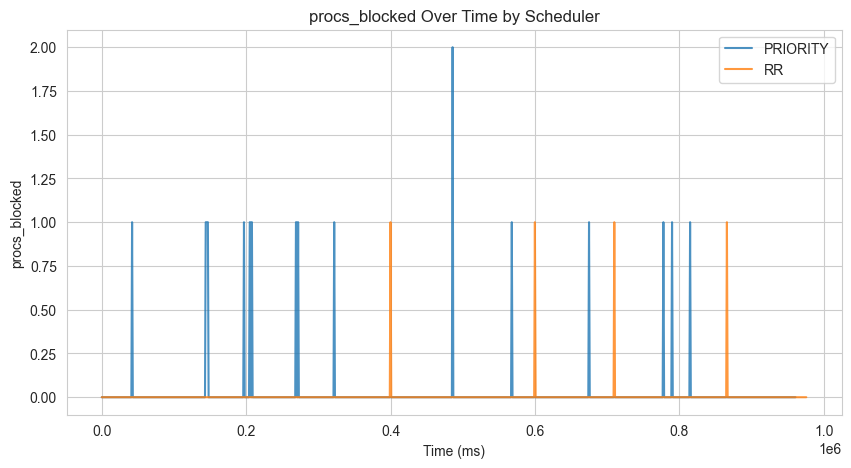

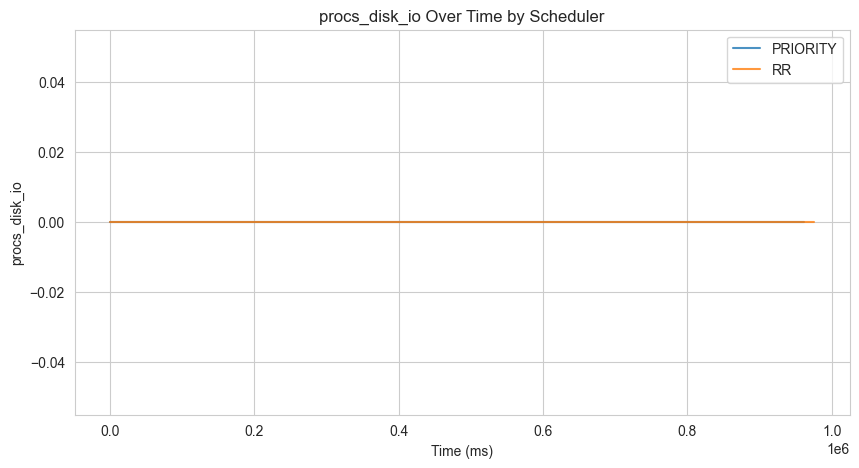

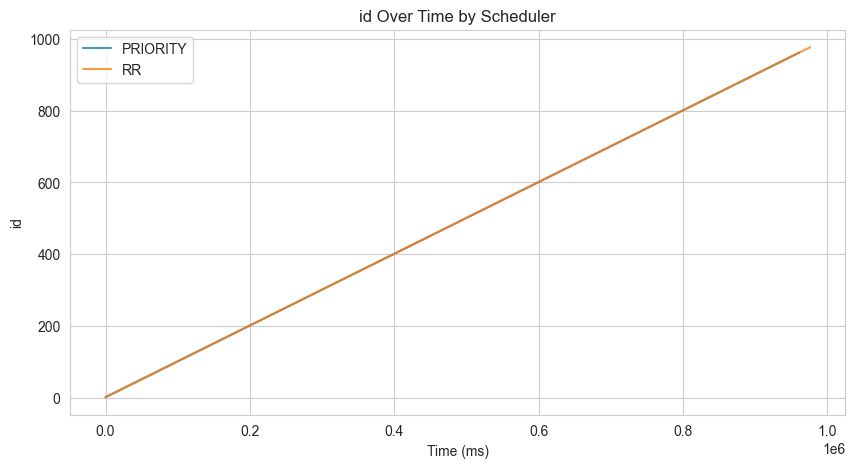

In [17]:
for col in metrics:
    plt.figure(figsize=(10,5))
    
    for sched in df["scheduler"].unique():
        sub = df[df["scheduler"] == sched]
        plt.plot(sub["time_ms"], sub[col], label=sched, alpha=0.8)
    
    plt.title(f"{col} Over Time by Scheduler")
    plt.xlabel("Time (ms)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()